In [1]:
#Import drive
from google.colab import drive
#Mount Google Drive
ROOT="/content/drive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/drive


In [3]:
#!pip install dash pandas scikit-learn

from dash import Dash, html, dcc, callback, Output, Input
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import requests
import io


KeyError: '__reduce_cython__'

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


In [4]:
import numpy as np

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

# Read Data

In [50]:
data_path = "https://raw.githubusercontent.com/lauramauricio/election-prediction-webapp/efe5785ebf31c3bf48d528e9aa2b6ebc7fa46d29/merged_dataset.csv"
df = pd.read_csv(data_path)

<ipython-input-50-2db63ce4b8c9>:2: DtypeWarning: Columns (11,14,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [51]:
column_drop = ["med1"]
df_clean = df.drop(column_drop, axis=1)

In [52]:
df_clean.head()

,year,userid,sex,age,educ,income,religion,sg1,sg9,sc1,sc7a,sc7b,pi1,lr1,pm3,vp1,vdn1b,pid1,pid2b,trust1,weighttot,party,total_gewahlt,total_men,total_women
0,1971,1,male,33.0,primary school,NaN,cath,French spoken,NaN,in training/formation,NaN,service class employees,rather not interested,NaN,materialist,yes,NaN,yes,sps/pss,NaN,0.936000,SP,46.0,43.0,3.0
1,1971,2,male,56.0,compulsory education,NaN,other,French spoken,NaN,full-time,NaN,other self-employed,rather not interested,NaN,mixed postmat,yes,NaN,yes,sps/pss,6.666666507720947,0.936000,SP,46.0,43.0,3.0
2,1971,3,male,49.0,primary school,NaN,cath,French spoken,NaN,full-time,NaN,semiskilled and unskilled workers,rather not interested,NaN,mixed mat,NaN,NaN,no,no party identification,6.666666507720947,1.000000,SP,46.0,43.0,3.0
3,1971,4,female,60.0,primary school,NaN,prot,French spoken,NaN,in household,NaN,NaN,not interested at all,NaN,mixed mat,no,NaN,no,no party identification,NaN,1.099000,SP,46.0,43.0,3.0
4,1971,5,female,39.0,compulsory education,NaN,prot,French spoken,NaN,without profession,NaN,service class employees,rather not interested,NaN,mixed mat,yes,fdp/prd,no,no party identification,3.3333332538604736,1.277453,SP,46.0,43.0,3.0


# Descriptives

In [53]:
# Group by year and calculate the share of voter for each party
yearly_party_share = df.groupby('year')['vdn1b'].value_counts(normalize=True).rename('share').reset_index()

print(yearly_party_share)  # Display the first few rows of the result

     year          vdn1b     share
0    1971        sps/pss  0.207490
1    1971        cvp/pdc  0.168016
2    1971        fdp/prd  0.159919
3    1971        svp/udc  0.134615
4    1971        ldu/adi  0.119433
..    ...            ...       ...
194  2019           lega  0.011376
195  2019  other parties  0.007438
196  2019    voted blank  0.002844
197  2019        edu/udf  0.002844
198  2019        csp/pcs  0.001094

[199 rows x 3 columns]


In [54]:
# Filter for the "sps/pss" party
sps_pss_share = yearly_party_share[yearly_party_share['vdn1b'] == 'sps/pss'][['year', 'share']]

# Calculate 200 divided by 'total_gewahlt' for each year
df['total_gewahlt_proportion'] = df['total_gewahlt']/200

# Calculate the average proportion per year
total_gewahlt_proportion_by_year = df.groupby('year')['total_gewahlt_proportion'].mean().reset_index()

# Merge the party share with the total_gewahlt proportion by year
comparison_df = pd.merge(sps_pss_share, total_gewahlt_proportion_by_year, on='year')
comparison_df.rename(columns={'share': 'sps_pss_share', 'total_gewahlt_proportion': 'total_gewahlt_proportion'}, inplace=True)

print("Comparison DataFrame:")
print(comparison_df)

Comparison DataFrame:
    year  sps_pss_share  total_gewahlt_proportion
0   1971       0.207490                     0.230
1   1975       0.284330                     0.275
2   1979       0.241739                     0.255
3   1987       0.155779                     0.205
4   1991       0.169463                     0.205
5   1995       0.320154                     0.270
6   1999       0.292002                     0.255
7   2003       0.290357                     0.260
8   2007       0.214362                     0.215
9   2011       0.238079                     0.230
10  2015       0.207882                     0.215
11  2019       0.169328                     0.195


# Transform into suitable Data

In [53]:
# Replace "NaN" values with 0 for both numeric and categorical data
df_clean = df_clean.fillna(0)

In [54]:
df_clean.head()


,year,userid,sex,age,educ,income,religion,sg1,sg9,sc1,sc7a,sc7b,pi1,lr1,pm3,vp1,vdn1b,pid1,pid2b,trust1,weighttot,party,total_gewahlt,total_men,total_women
0,1971,1,male,33.0,primary school,0,cath,French spoken,0,in training/formation,0,service class employees,rather not interested,0,materialist,yes,0,yes,sps/pss,0,0.936000,SP,46.0,43.0,3.0
1,1971,2,male,56.0,compulsory education,0,other,French spoken,0,full-time,0,other self-employed,rather not interested,0,mixed postmat,yes,0,yes,sps/pss,6.666666507720947,0.936000,SP,46.0,43.0,3.0
2,1971,3,male,49.0,primary school,0,cath,French spoken,0,full-time,0,semiskilled and unskilled workers,rather not interested,0,mixed mat,0,0,no,no party identification,6.666666507720947,1.000000,SP,46.0,43.0,3.0
3,1971,4,female,60.0,primary school,0,prot,French spoken,0,in household,0,0,not interested at all,0,mixed mat,no,0,no,no party identification,0,1.099000,SP,46.0,43.0,3.0
4,1971,5,female,39.0,compulsory education,0,prot,French spoken,0,without profession,0,service class employees,rather not interested,0,mixed mat,yes,fdp/prd,no,no party identification,3.3333332538604736,1.277453,SP,46.0,43.0,3.0


In [55]:
# Adjust display options to show more columns
pd.set_option('display.max_columns', None)

# Print all column names
print("Column names:", df_clean.columns)

# Print the first few rows
print("First few rows:")
print(df_clean.head())

Column names: Index(['year', 'userid', 'sex', 'age', 'educ', 'income', 'religion', 'sg1',
       'sg9', 'sc1', 'sc7a', 'sc7b', 'pi1', 'lr1', 'pm3', 'vp1', 'vdn1b',
       'pid1', 'pid2b', 'trust1', 'weighttot', 'party', 'total_gewahlt',
       'total_men', 'total_women'],
      dtype='object')
First few rows:
   year  userid     sex   age                  educ income religion  \
0  1971       1    male  33.0        primary school      0     cath   
1  1971       2    male  56.0  compulsory education      0    other   
2  1971       3    male  49.0        primary school      0     cath   
3  1971       4  female  60.0        primary school      0     prot   
4  1971       5  female  39.0  compulsory education      0     prot   

             sg1 sg9                    sc1 sc7a  \
0  French spoken   0  in training/formation    0   
1  French spoken   0              full-time    0   
2  French spoken   0              full-time    0   
3  French spoken   0           in household    0   
4 

In [56]:
column_drop = ["party", "total_gewahlt", "total_men", "total_women", "lr1", "pid2b"]
df_clean = df_clean.drop(column_drop, axis=1)

In [57]:
# Identify categorical columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns

# Exclude 'pid2b' from categorical columns
categorical_cols = [col for col in categorical_cols if col != 'vdn1b']

# Encode categorical columns using LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le


In [58]:
df_clean = df_clean.drop('year', axis=1)
df_clean

,userid,sex,age,educ,income,religion,sg1,sg9,sc1,sc7a,sc7b,pi1,pm3,vp1,vdn1b,pid1,trust1,weighttot
0,1,2,33.0,6,2,1,1,0,5,0,6,3,1,2,0,2,0,0.936000
1,2,2,56.0,2,2,3,1,0,2,0,2,3,3,2,0,2,9,0.936000
2,3,2,49.0,6,2,1,1,0,2,0,5,3,2,0,0,1,9,1.000000
3,4,1,60.0,6,2,4,1,0,4,0,0,1,2,1,0,1,0,1.099000
4,5,1,39.0,2,2,4,1,0,10,0,6,3,2,2,fdp/prd,1,5,1.277453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43664,43665,2,83.0,9,4,1,2,1,8,0,0,0,0,1,0,2,0,4.796863
43665,43666,1,42.0,7,0,4,2,2,7,0,0,2,0,2,GLP/Vert'libéraux,2,0,0.607058
43666,43667,1,46.0,7,5,1,1,2,9,0,0,2,0,2,sps/pss,2,0,0.084512
43667,43668,2,34.0,9,0,4,2,2,2,0,0,2,0,1,0,1,0,0.804412


In [59]:
df_clean["vdn1b"].unique()

array([0, 'fdp/prd', 'pda/pdt', 'sps/pss', 'other parties',
       'rep. (& vigil.)', 'cvp/pdc', 'svp/udc', 'lps/pls', 'evp/pep',
       'ldu/adi', 'csp/pcs', 'sd/ds', 'poch', 'voted blank', 'gps/pes',
       'fps/psl', 'fga/avf', 'right parties', 'left parties',
       'other comments', 'edu/udf', 'sol.', 'lega', 'psa (psu)',
       'centre parties', 'bdp', "GLP/Vert'libéraux", 'mcg'], dtype=object)

array(['sps/pss', 'no party identification', 'lps/pls', 'cvp/pdc',
       'pda/pdt', 'rep. (& vigil.)', 'csp/pcs', 'fdp/prd', 0, 'ldu/adi',
       'svp/udc', 'other parties', 'sd/ds', 'evp/pep', 'poch', 'fps/psl',
       'left parties', 'gps/pes', 'fga/avf', 'right parties', 'edu/udf',
       'sol.', 'lega', 'other comments', 'psa (psu)', 'mcg', 'bdp',
       "GLP/Vert'libéraux", 'centre parties'], dtype=object)

# Class Classification

In [60]:
df_clean.head()

,userid,sex,age,educ,income,religion,sg1,sg9,sc1,sc7a,sc7b,pi1,pm3,vp1,vdn1b,pid1,trust1,weighttot
0,1,2,33.0,6,2,1,1,0,5,0,6,3,1,2,0,2,0,0.936000
1,2,2,56.0,2,2,3,1,0,2,0,2,3,3,2,0,2,9,0.936000
2,3,2,49.0,6,2,1,1,0,2,0,5,3,2,0,0,1,9,1.000000
3,4,1,60.0,6,2,4,1,0,4,0,0,1,2,1,0,1,0,1.099000
4,5,1,39.0,2,2,4,1,0,10,0,6,3,2,2,fdp/prd,1,5,1.277453


In [61]:
# Convert vdn1b to a categorical text variable
df_clean['vdn1b'] = df_clean['vdn1b'].astype('category')

# Verify the conversion
df_clean['vdn1b'].dtype  # Should show 'category'

CategoricalDtype(categories=[                  0, 'GLP/Vert'libéraux',
                                'bdp',    'centre parties',
                            'csp/pcs',           'cvp/pdc',
                            'edu/udf',           'evp/pep',
                            'fdp/prd',           'fga/avf',
                            'fps/psl',           'gps/pes',
                            'ldu/adi',      'left parties',
                               'lega',           'lps/pls',
                                'mcg',    'other comments',
                      'other parties',           'pda/pdt',
                               'poch',         'psa (psu)',
                    'rep. (& vigil.)',     'right parties',
                              'sd/ds',              'sol.',
                            'sps/pss',           'svp/udc',
                        'voted blank'],
, ordered=False)

In [67]:
import pandas as pd

# Dictionary to rename categories
category_rename_mapping = {
    0: 'unknown',  # Example for numeric 0
    'GLP/Vert\'libéraux': "GLP",
    'bdp': 'BDP',
    'centre parties': 'Centre Parties',
    'csp/pcs': 'CSP',
    'cvp/pdc': 'CVP',
    'edu/udf': 'EDU',
    'evp/pep': 'EVP',
    'fdp/prd': 'FDP',
    'fga/avf': 'FGA',
    'fps/psl': 'FPS',
    'gps/pes': 'GPS',
    'ldu/adi': 'LdU',
    'left parties': 'Left Parties',
    'lega': 'Lega',
    'lps/pls': 'LPS',
    'mcg': 'MCG',
    'other comments': 'Other Comments',
    'other parties': 'Other Parties',
    'pda/pdt': 'PdA',
    'poch': 'POCH',
    'psa (psu)': 'PSA',
    'rep. (& vigil.)': 'Rep',
    'right parties': 'Right Parties',
    'sd/ds': 'SD',
    'sol.': 'Sol',
    'sps/pss': 'SP',
    'svp/udc': 'SVP',
    'voted blank': 'Voted Blank'
}

# Ensure the dictionary keys are matching the current categories
print("Category rename mapping keys:", category_rename_mapping.keys())

# Rename categories
df_clean['vdn1b'] = df_clean['vdn1b'].cat.rename_categories(category_rename_mapping)

# Verify the renaming
print("Renamed categories:", df_clean['vdn1b'].cat.categories)
print(df_clean.head())


Category rename mapping keys: dict_keys([0, "GLP/Vert'libéraux", 'bdp', 'centre parties', 'csp/pcs', 'cvp/pdc', 'edu/udf', 'evp/pep', 'fdp/prd', 'fga/avf', 'fps/psl', 'gps/pes', 'ldu/adi', 'left parties', 'lega', 'lps/pls', 'mcg', 'other comments', 'other parties', 'pda/pdt', 'poch', 'psa (psu)', 'rep. (& vigil.)', 'right parties', 'sd/ds', 'sol.', 'sps/pss', 'svp/udc', 'voted blank'])
Renamed categories: Index(['unknown', 'GLP', 'BDP', 'Centre Parties', 'CSP', 'CVP', 'EDU', 'EVP',
       'FDP', 'FGA', 'FPS', 'GPS', 'LdU', 'Left Parties', 'Lega', 'LPS', 'MCG',
       'Other Comments', 'Other Parties', 'PdA', 'POCH', 'PSA', 'Rep',
       'Right Parties', 'SD', 'Sol', 'SP', 'SVP', 'Voted Blank'],
      dtype='object')
   userid  sex   age  educ  income  religion  sg1  sg9  sc1  sc7a  sc7b  pi1  \
0       1    2  33.0     6       2         1    1    0    5     0     6    3   
1       2    2  56.0     2       2         3    1    0    2     0     2    3   
2       3    2  49.0     6       2

## All Classes

In [68]:
# Split the data into features and target
X = df_clean.drop('vdn1b', axis=1)
y = df_clean['vdn1b']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Step 2: Choose a model (Random Forest Classifier)
model = RandomForestClassifier()

# Step 3: Train the model
model.fit(X_train, y_train)

# Step 4: Evaluate the model
predictions = model.predict(X_test)

In [70]:
print(classification_report(y_test, predictions))

                precision    recall  f1-score   support

           BDP       0.29      0.08      0.12        64
           CSP       0.81      0.49      0.61        35
           CVP       0.59      0.65      0.62       698
Centre Parties       0.00      0.00      0.00         2
           EDU       0.75      0.12      0.20        26
           EVP       0.53      0.10      0.16        82
           FDP       0.64      0.67      0.65      1011
           FGA       0.00      0.00      0.00        18
           FPS       0.25      0.05      0.09        19
           GLP       0.61      0.33      0.43       123
           GPS       0.67      0.52      0.59       427
           LPS       0.82      0.34      0.48        93
           LdU       0.77      0.59      0.67        56
  Left Parties       0.00      0.00      0.00        18
          Lega       0.80      0.67      0.73        54
           MCG       0.50      0.24      0.32        17
Other Comments       0.53      0.22      0.31  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Most Common Parties

In [88]:
# Count occurrences of each party
party_counts = df_clean['vdn1b'].value_counts()

party_counts

vdn1b
unknown           16543
SP                 6516
FDP                5004
SVP                5004
CVP                3550
GPS                2235
Other Parties       669
GLP                 660
LPS                 479
EVP                 394
Other Comments      369
BDP                 334
LdU                 303
Lega                297
PdA                 250
CSP                 161
Voted Blank         148
EDU                 134
SD                  112
MCG                 104
FPS                  96
FGA                  94
Left Parties         83
Sol                  47
Right Parties        35
Rep                  21
POCH                 20
Centre Parties        6
PSA                   1
Name: count, dtype: int64

In [91]:
subset = df_clean[df_clean['vdn1b'].isin(['FDP','CVP','SP','SVP',
                                                        'LPS','LdU','EVP','CSP',
                                                        "PdA",'PSA', "GLP"])]

subset.head()

,userid,sex,age,educ,income,religion,sg1,sg9,sc1,sc7a,sc7b,pi1,pm3,vp1,vdn1b,pid1,trust1,weighttot
4,5,1,39.0,2,2,4,1,0,10,0,6,3,2,2,FDP,1,5,1.277453
7,8,1,48.0,6,2,4,1,0,4,0,3,3,2,2,PdA,2,0,1.833156
9,10,1,43.0,2,2,3,1,0,2,0,3,1,1,2,SP,1,0,1.033063
12,13,1,33.0,6,2,1,1,0,2,0,5,1,2,2,SP,2,0,1.033063
23,24,2,78.0,6,2,4,1,0,8,0,7,1,2,2,SP,1,9,1.033063


In [93]:
# Split the data into features and target
X = subset.drop('vdn1b', axis=1)
y = subset['vdn1b']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
print(subset.columns)

In [ ]:
subset

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Step 2: Choose a model (Random Forest Classifier)
model = RandomForestClassifier()

# Step 3: Train the model
model.fit(X_train, y_train)

# Step 4: Evaluate the model
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         CSP       1.00      0.72      0.84        29
         CVP       0.69      0.69      0.69       734
         EVP       0.73      0.14      0.24        78
         FDP       0.74      0.69      0.72       973
         GLP       0.84      0.40      0.54       130
         LPS       0.92      0.42      0.58        86
         LdU       0.90      0.67      0.77        66
         PdA       0.82      0.29      0.43        48
          SP       0.73      0.84      0.78      1341
         SVP       0.69      0.76      0.72       980

    accuracy                           0.72      4465
   macro avg       0.81      0.56      0.63      4465
weighted avg       0.73      0.72      0.71      4465



Saving Model

In [ ]:
import pickle
# Save the model
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Deep Learning Model

In [78]:
def sigmoid(z):
  z_clipped = np.clip(z, -500, 500)
  s = 1 / (1 + np.exp(-z_clipped))
  return s

In [79]:
def initialize_with_zeros(X):
  num_samples, num_features = X.shape
  weights = np.zeros(num_features).reshape(-1, 1)
  bias = 0.0
  assert(weights.shape == (num_features, 1))
  assert(isinstance(bias, float) or isinstance(bias, int))
  return weights, bias

In [80]:
def compute_cost(Y, y_predicted):
  epsilon = 1e-15 # Small constant to avoid division by zero
  num_samples = len(Y)
  cost = (-1/num_samples) * np.sum(Y * np.log(y_predicted + epsilon) + (1 - Y) * np.log(1 - y_predicted + epsilon))
  return cost

In [82]:
def propagate(weights, bias, X, Y):
  assert X.shape[0] == Y.shape[0], "Number of samples in X and Y must match"
  num_samples, num_features = X.shape

  linear_model = np.dot(weights.T, X.T) + bias
  y_predicted = sigmoid(linear_model)
  # Compute cost
  cost = compute_cost(Y, y_predicted)
  # BACKWARD PROPAGATION
  dw = (1 / num_samples) * np.dot(X.T, ((y_predicted- Y.T).T))
  db = (1 / num_samples) * np.sum(y_predicted-Y.T)

  assert(dw.shape == weights.shape)
  assert(db.dtype == float)
  cost = np.squeeze(cost)
  assert(cost.shape == ())
  grads = {"dw": dw, "db": db}
  return grads, cost

In [84]:
# GRADED FUNCTION: optimize

def optimize(weights, bias, X, Y, num_iterations, learning_rate):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    weights -- weights, a numpy array of size (1, num_features)
    bias -- bias, a scalar
    X -- data of shape (number of examples, num_features)
    Y -- true "label" vector (containing 0 if non-nith, 1 if nith), of shape (number of examples, 1)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule


    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    costs_history=[]
    # Gradient descent
    for i in range(num_iterations):


        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ###
        grads, cost = propagate(weights,bias,X,Y)
        ### END CODE HERE ###

        # Retrieve derivatives from grads
        dw = np.array(grads["dw"], dtype=float)
        db =  np.array(grads["db"], dtype=float)

        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        weights = weights.T - learning_rate * dw
        bias -= learning_rate * db
        ### END CODE HERE ###

        # Record the costs
        if i % 100 == 0:
            costs_history.append(np.mean(cost))

            # Print the cost every 100 training examples
            print ("Cost after iteration %i: %f" %(i, np.mean(cost)))

        weights=weights.T
        #print(weights.shape)

    params = {"w": weights,
                "b": bias}

    grads = {"dw": dw,
              "db": db}

    return params, grads, costs_history

In [85]:
# GRADED FUNCTION: predict

def predict(weights, bias, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    weights -- weights, a numpy array of size (num_samples, 1)
    bias -- bias, a scalar
    X -- data of size (num_samples, num_features)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    # Assertion for dimensions
    #assert X.shape[1] == len(weights), "Number of features in X must match the size of weights vector"

    linear_model = np.dot(weights, X.T) + bias
    y_predicted = sigmoid(np.array(linear_model, dtype=float))
    y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted[0]]

    return y_predicted_cls

In [105]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5):

    """
      Builds the logistic regression model by calling the function you've implemented previously

      Arguments:
      X_train -- training set represented by a numpy array of shape (num_samples_train, num_features)
      Y_train -- training labels represented by a numpy array (vector) of shape (num_samples_train, num_features)
      X_test -- test set represented by a numpy array of shape (num_samples_test, num_features)
      Y_test -- test labels represented by a numpy array (vector) of shape (num_samples_test, 1)
      num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
      learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()


      Returns:
      d -- dictionary containing information about the model.
    """

    ### START CODE HERE ###

    # initialize parameters with zeros (≈ 1 line of code)

    weights, bias = initialize_with_zeros(X_train)

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs_history =  optimize(weights, bias, X_train, Y_train, num_iterations, learning_rate)

    # Retrieve parameters w and b from dictionary "parameters"
    weights = parameters["w"]
    bias = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(weights, bias, X_test)
    Y_prediction_train = predict(weights, bias, X_train)


    ### END CODE HERE ###

    # Print train/test Errors

    accuracy_test = np.mean(Y_prediction_test ==Y_test.reshape(1,-1))
    print("Test Accuracy:", accuracy_test)

    accuracy_train = np.mean(Y_prediction_train == Y_train.reshape(1,-1))
    print("Test Accuracy:", accuracy_train)

    # Plot cost over iterations
    import matplotlib.pyplot as plt
    plt.plot(range(len(costs_history)), costs_history)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost vs. Iterations')
    plt.show()

    d = {"costs": costs_history,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train" : Y_prediction_train,
        "w" : weights,
        "b" : bias,
        "learning_rate" : learning_rate,
        "num_iterations": num_iterations}

    return d

# Apply to Data

In [106]:
### START CODE HERE ###
subset['vdn1b'] = pd.Categorical(subset['vdn1b']).codes
df_dummies_model = subset.copy()
# Setting 'y' to 1 where it equals "SVP"
df_dummies_model.loc[df_dummies_model['vdn1b'] == "SVP", 'vdn1b'] = 1
df_dummies_model.loc[df_dummies_model['vdn1b'] != 1, 'vdn1b'] = 0

<ipython-input-106-ca787c77528b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['vdn1b'] = pd.Categorical(subset['vdn1b']).codes


In [107]:
# train, test split
X_train,\
X_test, \
y_train,\
y_test = train_test_split(df_dummies_model.iloc[:,1:], df_dummies_model['vdn1b'], test_size=0.3)

# Display the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15625, 17)
X_test shape: (6697, 17)
y_train shape: (15625,)
y_test shape: (6697,)


Cost after iteration 0: 0.693147
Cost after iteration 100: 4.796235
Cost after iteration 200: 8.332147
Cost after iteration 300: 10.964567
Cost after iteration 400: 13.435141
Cost after iteration 500: 15.843487
Cost after iteration 600: 18.072496
Cost after iteration 700: 19.973161
Cost after iteration 800: 21.539593
Cost after iteration 900: 22.822536
Test Accuracy: 0.008063311930715246
Test Accuracy: 0.00736


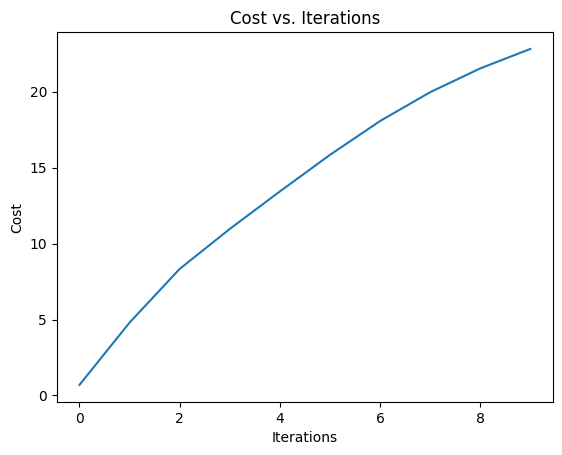

In [109]:
dict_data=model(X_train.values, y_train.values, X_test.values, y_test.values, num_iterations = 1000, learning_rate = 0.1)